# Определение перспективного тарифа для телеком-компании

## Описание проекта

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, необходимо проанализировать, какой тариф приносит больше денег.
Предварительный анализ тарифов мы сделаем на небольшой выборке клиентов. У нас есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов
**Тариф «Смарт»**

Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

### Описание данных

**Таблица users (информация о пользователях):**

- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

**Таблица calls (информация о звонках):**

- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**

- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**

- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**

- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Также мы будем принимать тот факт, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

## Загрузка библиотек и данных из файлов

Для начала загрузим все необходимые для исследования библиотеки:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
import math
import warnings
warnings.filterwarnings("ignore")

В этом исследовании мы будем использовать несколько датасетов. Ознакомимся с данными из них. 

In [2]:
try:
    users_data = pd.read_csv('/datasets/users.csv')
except:
    users_data = pd.read_csv('/Users/irina/Documents/praktikum/csv/users.csv')

In [3]:
users_data[:5]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Мы сохранили в переменной `users_data` информацию о пользователях. В таблице 8 столбцов, есть пропуски в столбце churn_date. Это столбец с датой прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). Позже мы подробнее ознакомимся с этими данными и исправим пропуски.

In [5]:
try:
    calls_data = pd.read_csv('/datasets/calls.csv')
except:
    calls_data = pd.read_csv('/Users/irina/Documents/praktikum/csv/calls.csv')

In [6]:
calls_data[:5]

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [7]:
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Мы сохранили в переменной `calls_data` информацию о звонках. В нашей таблице 4 столбца, 3 типа данных, пропусков данных нет. Также нет общего количества звонков по каждому user_id, мы обязательно сделаем подсчёты позже. 

In [8]:
try:
    internet_data = pd.read_csv('/datasets/internet.csv', index_col=0)
except:
    internet_data = pd.read_csv('/Users/irina/Documents/praktikum/csv/internet.csv', index_col=0)

In [9]:
internet_data[:5]

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [10]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


Мы сохранили в переменной `internet_data` информацию об интернет-сессиях. В нашей таблице 5 столбцов, 3 типа данных, пропусков данных нет. Есть один столбец Unnamed: 0, позже мы изменим его название на более удобное для работы. 

In [11]:
try:
    messages_data = pd.read_csv('/datasets/messages.csv')
except:
    messages_data = pd.read_csv('/Users/irina/Documents/praktikum/csv/messages.csv')

In [12]:
messages_data[:5]

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [13]:
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Мы сохранили в переменной `messages_data` информацию о сообщениях. В таблице 3 столбца, 2 типа данных, пропусков данных нет. Стоит отметить, что столбец user_id имеет тип данных int64. Также стоит отметить, что есть даты сообщений, число по каждому id, но нет их общего количества, позже мы посчитаем количество сообщений по каждому user_id по дням. 

In [14]:
try:
    tariffs_data = pd.read_csv('/datasets/tariffs.csv')
except:
    tariffs_data = pd.read_csv('/Users/irina/Documents/praktikum/csv/tariffs.csv')

In [15]:
tariffs_data[:5]

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [16]:
tariffs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Мы сохранили в переменной `tariffs_data` информацию о тарифах. В таблице 8 столбцов по два значения в каждом, пропусков нет. Позже мы подробнее ознакомимся с этими данными. 

**Вывод**

Мы загрузили необходимые для работы библиотеки и файлы. Данные датасетов в большинстве своё готовы для работы, есть небольшие детали, по типу пропусков данных, также мы заменим типы данных в некоторых столбцах (например, есть столбцы, в которых содержится дата, такие столбцы нужно привести к соответствующему виду) и округлим необходимые значения. 

## Предобработка данных

### Замена пропущенных значений

Исходя из данных в предыдущем пункте нам нужно обработать пропуски в столбце churn_date. В описании данных есть объяснение на этот счёт - это столбец с датой прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). Поэтому заменять пропущенные значения мы не будем, оставим данные как есть. 

### Замена типов данных и округление 

Заменим типы данных на более подходящие для удобства расчетов. Также округлим до целых значений значения минут разговора. Важное уточнение - округление всегда будет происходить в большую сторону, даже если он длился всего 1 секунду, будет засчитан как 1 минута.

В наших таблицах есть столбцы с датами: reg_date, churn_date, call_date, session_date, message_date. Сразу риведем данные в этих столбцах к соответствующему типу datetime64:

In [17]:
users_data['reg_date'] = pd.to_datetime(users_data['reg_date'], format='%Y-%m-%d')
users_data['churn_date'] = pd.to_datetime(users_data['churn_date'], format='%Y-%m-%d')
calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format='%Y-%m-%d')
internet_data['session_date'] = pd.to_datetime(internet_data['session_date'], format='%Y-%m-%d')
messages_data['message_date'] = pd.to_datetime(messages_data['message_date'], format='%Y-%m-%d')

**Теперь посмотрим по порядку по каждому датасету, какие ещё есть особенности. Начнем с users_data:**

In [18]:
users_data.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


У нас всего 2 столбца с численными данными. Никаких особенности в данных нет, средний возраст пользователя составляет 47 лет.

**Теперь посмотрим таблицу calls_data:**

In [19]:
calls_data.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Никаких особенностей в столбце с длительностью разговора не наблюдается, все данные в пределах нормального распределения. Нужно поработать с типом данных - округлить все вещественные числа в столбце duration до целых в большую сторону, согласно политике компании. Посмотрим на данные в столбце в целом - есть и нулевые значения, их мы трогать не будем, т.к. это пропущенные звонки. Но, например, время длительности звонка в 5.18 нам нужно округлить до 6 минут, т.к. даже 1 секунда каждый минуты, будет засчитана как 1 минута. Так поступим со всеми ненулевыми значениями, и после переведем тип данных в формат целочисленных.

In [20]:
calls_data[['duration']]

,duration
0,0.00
1,0.00
2,2.85
3,13.80
4,5.18
...,...
202602,0.76
202603,18.83
202604,10.81
202605,4.27


In [21]:
calls_data['duration'] = np.ceil(calls_data['duration']).astype('int')

In [22]:
calls_data[['duration']][:10]

,duration
0,0
1,0
2,3
3,14
4,6
5,0
6,0
7,19
8,19
9,0


In [23]:
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


Мы преобразовали данные в этом датафрейме к подходящим для вычислений типам. 

**Посмотрим таблицу internet_data:**

In [24]:
internet_data[:10]

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [25]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


In [26]:
internet_data.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


Также у нас есть столбец Unnamed: 0 в этом датасете, который судя по всему дублирует индексы строк. В загрузке библиотек мы с помощью index_col=0 убрали его, т.к. для расчетов он нам не понадобится

In [27]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


Теперь в нашей таблицы остались только данные, необходимые для дальнейшего анализа. Тип данных количества использованных мегабайт изменять не будем, чуть позже добавим дополнительный столбец с количеством гигабайт и там уже всё округлим. 

Можно На этом этап предобработки данных завершен, перейдём к расчетам и добавлении результатов таблицы. 

## Расчеты и добавление результатов

### Расчёт, добавление и округление интернет-трафика из МБ в ГБ

Мы знаем, что в одном гигабайте 1024 мегабайт. Разделим значения столбца mb_used на 1024 и сохраним результаты в новом столбце 'gb_used' 

In [28]:
internet_data['gb_used'] = internet_data['mb_used'] / 1024

In [29]:
internet_data[['gb_used']][:10]

,gb_used
0,0.110303
1,1.028135
2,1.169199
3,0.537373
4,0.295469
5,0.390596
6,0.527422
7,0.405957
8,0.493555
9,0.337441


У нас получился столбец использованного трафика в гб и вещественных числах. Позже мы посмотрим, сколько у пользователя вышло трафика за месяц и округлим в большую сторону. 

In [30]:
internet_data[['gb_used']][:10]

,gb_used
0,0.110303
1,1.028135
2,1.169199
3,0.537373
4,0.295469
5,0.390596
6,0.527422
7,0.405957
8,0.493555
9,0.337441


Отлично, мы успешно перевели использованные мегабайты в гигабайты. 

### Подсчет количества сделанных звонков и израсходованных минут разговора по месяцам

Сделаем сводную таблицу, чтобы удобно было всю информацию видеть сразу. Индексами будут user_id и месяцы, а подсчет будем вести по столбцу duration. Для этого сначала в основном датасете создадим столбец с месяцами. А после сохраним данные в переменную `calls_data_sorted`

In [31]:
calls_data['month'] = calls_data['call_date'].dt.month

In [32]:
calls_data_sorted = calls_data.pivot_table(
    index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count']).reset_index()
calls_data_sorted.columns = ['user_id', 'month', 'minutes','calls']
calls_data_sorted

,user_id,month,minutes,calls
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58
...,...,...,...,...
3169,1498,10,247,41
3170,1499,9,70,9
3171,1499,10,449,68
3172,1499,11,612,74


Отлично, получилось очень наглядно - в первом столбце мы видим id пользователя, потом идет разбивка по месяцам, далее общее количество минут по месяцам и количество звонков.

### Подсчёт количества отправленных сообщений по месяцам

По аналогии с пунктом 4.2 сделаем сводную таблицу, предварительно добавив столбец с номером месяца в основной датасет. Готовый результат сохраним в переменную `messages_data_sorted`

In [33]:
messages_data['month'] = messages_data['message_date'].dt.month

In [34]:
messages_data[:10]

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
5,1000_5,2018-06-20,1000,6
6,1000_6,2018-11-19,1000,11
7,1000_7,2018-10-29,1000,10
8,1000_8,2018-06-25,1000,6
9,1000_9,2018-12-18,1000,12


In [35]:
messages_data_sorted = messages_data.pivot_table(
    index=['user_id', 'month'], values='id', aggfunc=['count']).reset_index()
messages_data_sorted.columns = ['user_id', 'month', 'sms_count']
messages_data_sorted

,user_id,month,sms_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Таблица пригодится нам в будущих расчетах. 

### Подсчёт объема израсходованного интернет-трафика по месяцам

Добавим в датасет с информацией об интернет-трафике столбец с месяцами, после создадим сводную таблицу, израсходованного интернет-трафика по месяцам и сохраним её в переменной `internet_data_sorted` и округлим использованные гигабайты в большую сторону.

In [36]:
internet_data['month'] = internet_data['session_date'].dt.month

In [37]:
internet_data_sorted = internet_data.pivot_table(
    index=['user_id', 'month'], values='gb_used', aggfunc=['sum'])
internet_data_sorted.columns = ['gb_count']

In [38]:
internet_data_sorted['gb_count'] = np.ceil(internet_data_sorted['gb_count']).astype('int')

In [39]:
internet_data_sorted

gb_count
user_id month          
1000    5             3
        6            23
        7            14
        8            14
        9            15
...                 ...
1498    10           21
1499    9             2
        10           18
        11           18
        12           13

[3203 rows x 1 columns]

Таблица пригодится нам в будущих расчетах. 

### Подсчёт помесячной выручки с каждого пользователя

Для того, чтобы посчитать выручку с каждого пользователя по месяцам, вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, а остаток умножим на значение из тарифного плана. Прибавим абонентскую плату, соответствующую тарифному плану

Сначала объединим наши подсчеты из пунктов выше. Начнем с объединения данных по звонкам и смс:

In [40]:
calls_sms_merged = calls_data_sorted.merge(messages_data_sorted, on=['user_id', 'month'], how='outer')

In [41]:
calls_sms_merged[:20]

,user_id,month,minutes,calls,sms_count
0,1000,5,159.0,22.0,22.0
1,1000,6,172.0,43.0,60.0
2,1000,7,340.0,47.0,75.0
3,1000,8,408.0,52.0,81.0
4,1000,9,466.0,58.0,57.0
5,1000,10,350.0,57.0,73.0
6,1000,11,338.0,43.0,58.0
7,1000,12,333.0,46.0,70.0
8,1001,11,430.0,59.0,NaN
9,1001,12,414.0,63.0,NaN


In [42]:
calls_sms_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3212
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    3213 non-null   int64  
 1   month      3213 non-null   int64  
 2   minutes    3174 non-null   float64
 3   calls      3174 non-null   float64
 4   sms_count  2717 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 150.6 KB


Можно заметить пропущенные значения в полях. Это значит, что некоторые не использовали те или иные возможности, которые предоставляет компания. Например, звонили, но не писали смс или наоборот. Заменим пропущенные значения на 0, но позже, когда присоединим таблицу с интернет-трафиком. 

Теперь объединим полученную таблицу с данными по интернет-трафику:

In [43]:
merged_data = calls_sms_merged.merge(internet_data_sorted, on=['user_id', 'month'], how='outer')

In [44]:
merged_data

,user_id,month,minutes,calls,sms_count,gb_count
0,1000,5,159.0,22.0,22.0,3.0
1,1000,6,172.0,43.0,60.0,23.0
2,1000,7,340.0,47.0,75.0,14.0
3,1000,8,408.0,52.0,81.0,14.0
4,1000,9,466.0,58.0,57.0,15.0
...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17.0
3210,1489,10,NaN,NaN,21.0,20.0
3211,1489,11,NaN,NaN,20.0,18.0
3212,1489,12,NaN,NaN,35.0,17.0


In [45]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    3214 non-null   int64  
 1   month      3214 non-null   int64  
 2   minutes    3174 non-null   float64
 3   calls      3174 non-null   float64
 4   sms_count  2717 non-null   float64
 5   gb_count   3203 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


В таблице есть пропущенные значения, посмотрим их количество:

In [46]:
merged_data.isna().sum()

user_id        0
month          0
minutes       40
calls         40
sms_count    497
gb_count      11
dtype: int64

Равное количество пропущенных значений в столбцах с минутами и количеством звонков, это можно объяснить тем, что некоторые абоненты не звонят по телефону в принципе, а пользуются только смс и интернет-трафиком. По такому же принципу есть пропуски в столбцах с смс сообщениями и использованным трафиком - людям удобнее общаться по телефону, они находятся в роуминге либо есть какие то технические сложности с использованием доступа в интернет, но так как нулевых значений использованного трафика всего 11, каждый случай можно рассмотреть индивидуально при необходимости. 

Теперь добавим в нашу таблицу с данными по id информацию об абонентах и тарифных планах. Для этого выделим в отдельный датафрейм информацию об абонентах - город, тарифный план:

In [47]:
all_users = users_data.loc[:,['user_id', 'city', 'tariff']]

In [48]:
all_users[:5]

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra


Теперь добавим эти данные в нашу таблицу merged_data:

In [49]:
merged_data = merged_data.merge(all_users, on=['user_id'], how='outer')

In [50]:
merged_data 

,user_id,month,minutes,calls,sms_count,gb_count,city,tariff
0,1000,5.0,159.0,22.0,22.0,3.0,Краснодар,ultra
1,1000,6.0,172.0,43.0,60.0,23.0,Краснодар,ultra
2,1000,7.0,340.0,47.0,75.0,14.0,Краснодар,ultra
3,1000,8.0,408.0,52.0,81.0,14.0,Краснодар,ultra
4,1000,9.0,466.0,58.0,57.0,15.0,Краснодар,ultra
...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,20.0,Санкт-Петербург,smart
3212,1489,11.0,NaN,NaN,20.0,18.0,Санкт-Петербург,smart
3213,1489,12.0,NaN,NaN,35.0,17.0,Санкт-Петербург,smart
3214,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra


Мы видим пропуски значений: у двух последних абонентов пропуски во всех колонках - возможно сначала эти абоненты подключились, но потом, возможно, передумали пользоваться. Посмотрим на данные этих пользователей отдельно:

In [51]:
users_data[(users_data.user_id==1128)|(users_data.user_id==1371)]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


По дате прекращения пользования тарифом видно, что Ксения расторгла договор через 8 дней после оформления, а Ириней расторг через 5 дней. Оба абонента не пользовались услугами вообще. Поэтому смело можно удалить этих абонентов из нашей таблицы, т.к. здесь представлены оба тарифные плана - некритично отсечь эти данные. Нужно уточнить у менеджеров, была ли списана абонентская плата, т.к. у нас нет информации, предоплаченные ли тарифные планы или нет.

In [52]:
merged_data = merged_data.drop([3214, 3215])

In [53]:
merged_data.tail(5)

,user_id,month,minutes,calls,sms_count,gb_count,city,tariff
3209,1489,8.0,NaN,NaN,17.0,11.0,Санкт-Петербург,smart
3210,1489,9.0,NaN,NaN,32.0,17.0,Санкт-Петербург,smart
3211,1489,10.0,NaN,NaN,21.0,20.0,Санкт-Петербург,smart
3212,1489,11.0,NaN,NaN,20.0,18.0,Санкт-Петербург,smart
3213,1489,12.0,NaN,NaN,35.0,17.0,Санкт-Петербург,smart


Мы убрали двух абонентов, информации о которых нет вообще за выбираемый период. Теперь заменим значения NaN на 0 для удобства расчетов и поменяем типы данных в колонках с информации о звонках, смс и трафике на целочисленные:

In [54]:
merged_data = merged_data.fillna(0)

In [55]:
merged_data[['month', 'minutes', 'calls', 'sms_count', 'gb_count']
           ] = merged_data[['month', 'minutes', 'calls', 'sms_count', 'gb_count']].convert_dtypes()

In [56]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    3214 non-null   int64 
 1   month      3214 non-null   Int64 
 2   minutes    3214 non-null   Int64 
 3   calls      3214 non-null   Int64 
 4   sms_count  3214 non-null   Int64 
 5   gb_count   3214 non-null   Int64 
 6   city       3214 non-null   object
 7   tariff     3214 non-null   object
dtypes: Int64(5), int64(1), object(2)
memory usage: 241.7+ KB


Убедились, что пропусков нет, типы данных, нужные нам для расчетов. 

Теперь посчитаем выручку. Для этого мы будем использовать таблицы merged_data и tariffs_data. Посмотрим еще раз на особенности тарифных планов:

In [57]:
tariffs_data

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Есть особенность - в этой таблице указано количество мегабайт, входящих в тарифный план. Добавим столбец с гигабайтами:

In [58]:
tariffs_data['gb_per_month_included'] = (tariffs_data['mb_per_month_included'] / 1024).astype('int')

In [59]:
tariffs_data

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15
1,1000,30720,3000,1950,150,1,1,ultra,30


Напишем функцию, которая поможет нам посчитать бесплатный лимит из суммарного количества минут, сообщений и интернет-трафика, а остаток умножим на значение из тарифного плана. Прибавим абонентскую плату, соответствующую тарифному плану и применим функцию к нашей таблице merged_data.

In [64]:
def income(merged_data):
    minutes = merged_data['minutes']
    sms_count = merged_data['sms_count']
    gb_count = merged_data['gb_count']
    tariff = merged_data['tariff']
    if tariff == 'smart':
        if minutes > tariffs_data.loc[0,'minutes_included']: #минуты сверх тарифа
            over_min = (minutes - tariffs_data.loc[0,'minutes_included']) * tariffs_data.loc[0,'rub_per_minute'] 
        else:
            over_min = 0
        if sms_count > tariffs_data.loc[0,'messages_included']: #сообщения сверх тарифа
            over_sms = (sms_count - tariffs_data.loc[0,'messages_included']) * tariffs_data.loc[0,'rub_per_message'] 
        else:
            over_sms = 0
        if gb_count > tariffs_data.loc[0,'gb_per_month_included']: #гб сверх тарифа
            over_gb = (gb_count - tariffs_data.loc[0,'gb_per_month_included']) * tariffs_data.loc[0,'rub_per_gb'] 
        else:
            over_gb = 0 
        return over_min + over_sms + over_gb + tariffs_data.loc[0,'rub_monthly_fee'] #стоимость услуг сверх тарифа + абонплата
    elif tariff == 'ultra':
        if minutes > tariffs_data.loc[1,'minutes_included']: ##минуты сверх тарифа
            over_min = (minutes - tariffs_data.loc[1,'minutes_included']) * tariffs_data.loc[1,'rub_per_minute'] 
        else:
            over_min = 0
        if sms_count > tariffs_data.loc[1,'messages_included']: #сообщения сверх тарифа
            over_sms = (sms_count - tariffs_data.loc[1,'messages_included']) * tariffs_data.loc[1,'rub_per_message']
        else:
            over_sms = 0
        if gb_count > tariffs_data.loc[1,'gb_per_month_included']: #гб сверх тарифа
            over_gb = (gb_count - tariffs_data.loc[1,'gb_per_month_included']) * tariffs_data.loc[1,'rub_per_gb'] 
        else:
            over_gb = 0
        return over_min + over_sms + over_gb + tariffs_data.loc[1,'rub_monthly_fee'] #стоимость услуг сверх тарифа + абонплата

merged_data['income_rub'] = merged_data.apply(income, axis=1)
merged_data

,user_id,month,minutes,calls,sms_count,gb_count,city,tariff,income_rub
0,1000,5,159,22,22,3,Краснодар,ultra,1950.0
1,1000,6,172,43,60,23,Краснодар,ultra,1950.0
2,1000,7,340,47,75,14,Краснодар,ultra,1950.0
3,1000,8,408,52,81,14,Краснодар,ultra,1950.0
4,1000,9,466,58,57,15,Краснодар,ultra,1950.0
...,...,...,...,...,...,...,...,...,...
3209,1489,8,0,0,17,11,Санкт-Петербург,smart,550.0
3210,1489,9,0,0,32,17,Санкт-Петербург,smart,950.0
3211,1489,10,0,0,21,20,Санкт-Петербург,smart,1550.0
3212,1489,11,0,0,20,18,Санкт-Петербург,smart,1150.0


Теперь в нашей таблице с данными появились суммы помесячной выручки по каждому месяцу у каждого абонента. На этом мы можем завершить этап расчётов и добавлений результатов в таблицы и приступить к анализу данных. 

## Анализ данных

В этом пункте мы опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы и опишем распределения.

### Посмотрим сводную таблицу по тарифам, в которой посчитаны среднее количество, медиана, дисперсию и стандартное отклонение:

In [62]:
merged_data.pivot_table(index = 'tariff', values = [
    'minutes', 'sms_count', 'gb_count', 'income_rub'
], aggfunc = ['mean', 'median', 'var', 'std'])

mean                                       median             \
         gb_count   income_rub     minutes  sms_count gb_count income_rub   
tariff                                                                      
smart   16.328847  1289.973531  417.934948  33.384029     17.0       1023   
ultra   19.494416  2070.152284   526.62335  49.363452     19.0       1950   

                                var                                \
       minutes sms_count   gb_count     income_rub        minutes   
tariff                                                              
smart    422.0      28.0  33.028705  669785.708006   36219.315784   
ultra    518.0      38.0  97.091686  141516.745079  100873.633397   

                          std                                     
          sms_count  gb_count  income_rub     minutes  sms_count  
tariff                                                            
smart    796.812958  5.747061  818.404367  190.313730  28.227876  
ultra   2285.266143  9.853511  376.187114  317.606098  47.804457

Обратим внимание, что дисперсии выручки у нас не равны, эта информация пригодится нам при проверке гипотез. 

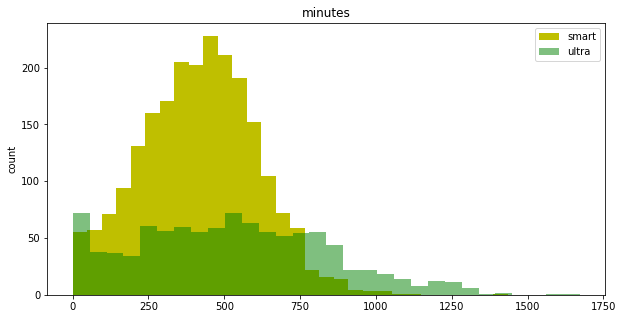

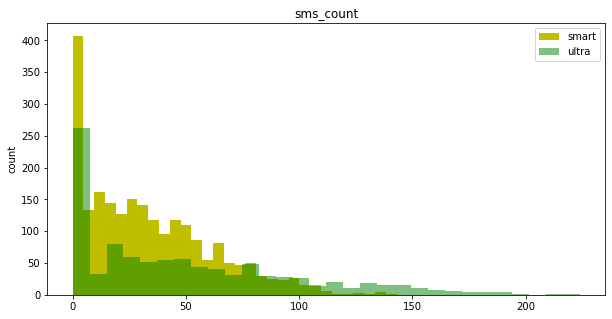

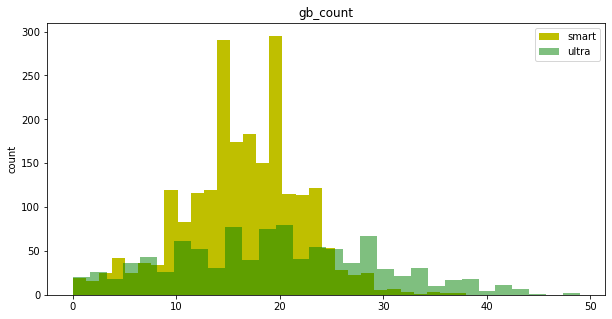

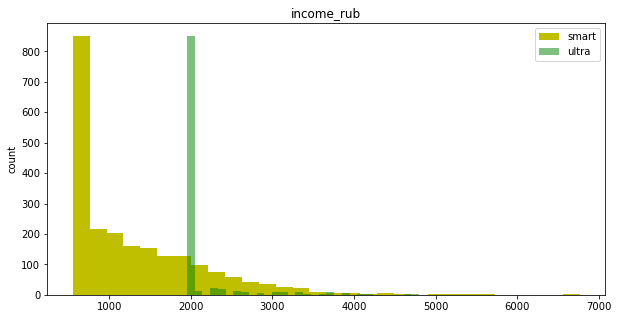

In [65]:
title=['minutes','sms_count','gb_count','income_rub']
tariffs = ['ultra','smart']

for column in title:
    merged_data.loc[merged_data.loc[:,'tariff'] == 'smart'][
        column].plot(kind = 'hist', bins = 30, label = 'smart', color = 'y', figsize = (10,5))
    merged_data.loc[merged_data.loc[:,'tariff'] == "ultra"][
        column].plot(kind = 'hist', bins = 30, alpha =0.5, label = 'ultra', color = 'g', figsize = (10,5))
        
    plt.title(column)
    plt.ylabel('count')
    plt.legend()
    plt.show()

Согласно нашим гистограммам можно сделать несколько выводов:

* Минуты. Согласно гистограмме мы можем видеть, что длиннее всего разговоры у пользователей тарифом SMART, хотя пакет минут меньше в 6 раз и каждая минута разговора стоит в 3 раза дороже, чем на тарифе ULTRA. Можно предложить таким абонентам перейти на тариф ULTRA. 

* Сообщения. Общая тенденция показывает, что основная масса абонентов отправляет от 1 до 75 сообщений в месяц. Пользователи тарифа SMART чаще выходят за рамки пакета в 50 сообщений, то есть чаще приносят дополнительный доход компании.

* Интернет-трафик. Мы видим, что в среднем пользователи тарифа SMART используют около 17гб интернет-трафика в месяц, а в ULTRA около 20гб. То есть в целом пользователи тарифа SMART в этом пункте тоже приносят дополнительный доход от превышения трафика. 

* Суммарные траты. Мы видим, что в основном людям хватает лимитов по тарифным планам, и пики у нас идут по оплатам 550 и 1950 руб соответственно. Но также, мы видим, что есть абоненты, которые оплачивают превышения тарифа сверх стоимости, но переплата небольшая, то есть мотивации перейти на другой тариф всё же скорее всего не появится. Исключение составляют лишь пользователи, которые платят свыше 1950 рублей за тариф SMART - им стоит предложить перейти на тариф ULTRA.

### Посмотрим на показатели пакетных услуг по каждому тарифу помесячно.

Начнем с общей выручки:

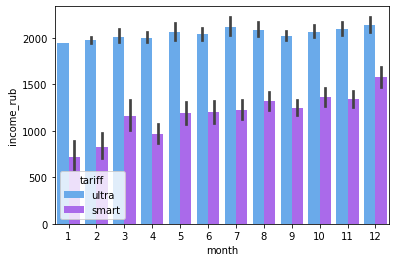

In [66]:
ax = sns.barplot(x='month', y='income_rub', data=merged_data, hue='tariff', palette='cool')

Можно заметить, что пользователи тарифа ULTRA в среднем практически не выбиваются из лимита пакетных услуг, которые включены в тариф. А вот абоненты SMART очень часто превышают лимит, тем самым принося дополнительную прибыль компании за счет оплаты услуг сверх тарифного плана. Виден уверенный рост объемов выручки по тарифу SMART от начала года к концу. 

Теперь посмотрим на количество минут, вспомнив, какие объемы пакетных услуг у нас есть:

In [67]:
tariffs_data

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


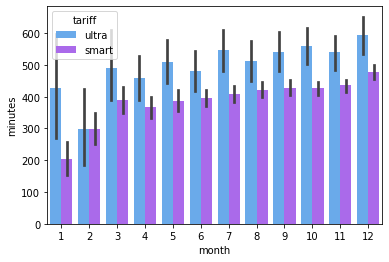

In [68]:
ax = sns.barplot(x='month', y='minutes', data=merged_data, hue='tariff', palette='cool')

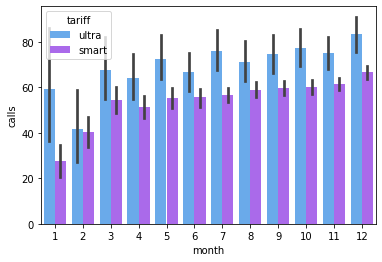

In [69]:
ax = sns.barplot(x='month', y='calls', data=merged_data, hue='tariff', palette='cool')

Пользователи обоих тарифов в среднем не превышают свои пакеты минут, но абоненты тарифа ULTRA совершают больше звонков, а у абонентов SMART телефонные разговоры длиннее.

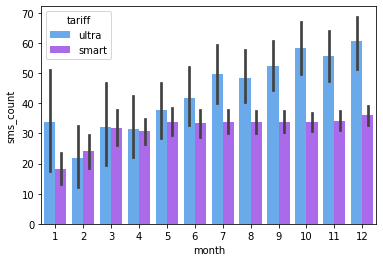

In [70]:
ax = sns.barplot(x='month', y='sms_count', data=merged_data, hue='tariff', palette='cool')

По графику виден рост среднего объёма отправляемых сообщений у пользователей тарифа ULTRA с мая по декабрь, в то время как пользователи SMART вышли на плато в мае месяце и средний объем отправляемых сообщений не меняется, то есть пересматривать объем пакета сообщений в тарифе не требуется. 

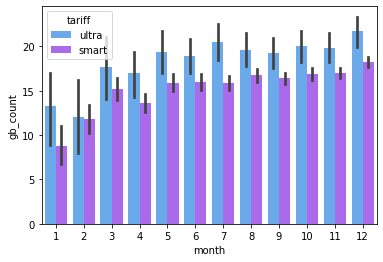

In [71]:
ax = sns.barplot(x='month', y='gb_count', data=merged_data, hue='tariff', palette='cool')

Анализ объема интернет-трафика дает возможность оценить, что в среднем пользователи тарифа SMART чаще выходят за рамки предоставляемого пакета трафика, тем самым оплачивая услуги сверх тарифного плана. В целом по выборке можно судить, что тарифный план SMART более прибыльный для компании. 

## Проверка гипотез

В этом пункте нам предстоит проверить две гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Пороговое значение *alpha* будем использовать равным 0.01, т.к. уровень достоверности наших данных достаточно высок.

### Проверим первую гипотезу: cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

* Нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны.
* Альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Создадим две выборки - отсортируем значения выручки по каждому тарифу и сохраним в соответствующие переменные:

In [72]:
smart_income = merged_data.query('tariff =="smart"')['income_rub'].values
ultra_income = merged_data.query('tariff =="ultra"')['income_rub'].values

Мы будем проверять гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, поэтому будем использовать метод st.ttest_ind и укажем, что дисперсии не равны:

In [73]:
alpha = .01
results = st.ttest_ind(smart_income, ultra_income, equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


Уровень значимости между сравниваемыми значениями достаточно велик, нулевую гипотезу отвергаем, принимаем альтернативную гипотезу - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Также напомним себе про средние выручки, чтобы наглядно убедиться в исходе эксперимента:

In [74]:
merged_data.groupby(['tariff'])['income_rub'].mean().to_frame()

,income_rub
tariff,
smart,1289.973531
ultra,2070.152284


Наглядно тоже можно сделать выбор в пользу альтернативной гипотезы. 

### Проверим вторую гипотезу: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

* Нулевая гипотеза: средняя выручка пользователей из Москвы и пользователей из других регионов тарифов «Ультра» и «Смарт» не различается.
* Альтернативная гипотеза: средняя выручка пользователей из Москвы и пользователей из других регионов тарифов «Ультра» и «Смарт» различается.

Создадим две выборки - таблицы с населенными пунктами: отдельно Москва и отдельно все остальные населенные пункты:

In [75]:
moscow_income = merged_data.query('city == "Москва"')['income_rub'].values
locality_income = merged_data.query('city != "Москва"')['income_rub'].values

Снова будем использовать метод st.ttest_ind и укажем, что дисперсии не равны:

In [76]:
alpha = 0.01
results = st.ttest_ind(moscow_income, locality_income, equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha): 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу - средняя выручка пользователей из Москвы и пользователей из других регионов тарифов «Ультра» и «Смарт» не различается, то есть местонахождение абонента не влияет на среднюю выручку. Посмотрим, как это выглядит на графике:

Text(0, 0.5, 'Города')

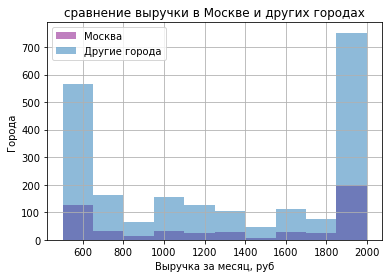

In [77]:
ax = merged_data['income_rub'][merged_data['city'] == 'Москва'].plot(
    kind='hist',
    range=(500, 2000),
    bins=10,
    linewidth=5,
    alpha=0.5,
    title= 'сравнение выручки в Москве и других городах',
    label='Москва',
    color='purple',
    legend=True
)
merged_data['income_rub'][merged_data['city'] != 'Москва'].plot(
    kind='hist',
    range=(500, 2000),
    bins=10,
    linewidth=5,
    alpha=0.5,
    label='Другие города',
    ax=ax,
    grid=True,
    legend=True
) 
plt.xlabel('Выручка за месяц, руб', fontsize=10, color='black')
plt.ylabel('Города', fontsize=10, color='black')

По нашей гистограмме также заметно, что у абонентов из других регионов численное преимущество, а в целом пики идентичны и нет отличий в средней выручке по регионам. 

## Общий вывод

В данном исследовании были проанализированы массивы данных с информацией по двум тарифным планам оператора сотовой связи. В процессе предобработки данных были найдены и заменены пропуски, исправлены типы данных и удален столбец, дублирующий индексы в таблице - он нам не нужен для расчетов. 

1. В процессе исследования были рассчитаны и добавлены в таблицы следующие данные: 

* Расчёт, добавление и округление интернет-трафика из МБ в ГБ;
* Подсчет количества сделанных звонков и израсходованных минут разговора по месяцам;
* Подсчёт количества отправленных сообщений по месяцам;
* Подсчёт помесячной выручки с каждого пользователя.

2. В ходе анализа данных пункте мы описали поведение клиентов оператора, исходя из выборки и построили гистограммы:

Минуты. Согласно гистограмме мы можем видеть, что длиннее всего разговоры у пользователей тарифом SMART, хотя пакет минут меньше в 6 раз и каждая минута разговора стоит в 3 раза дороже, чем на тарифе ULTRA. Можно предложить таким абонентам перейти на тариф ULTRA.

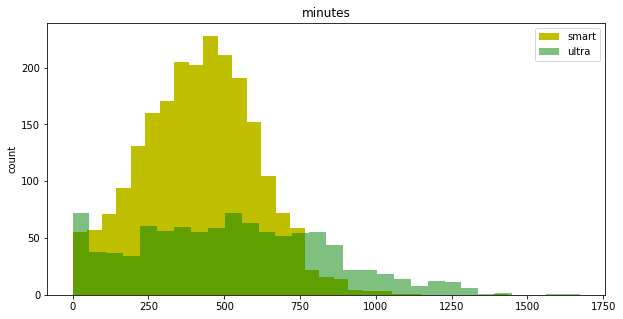

Сообщения. Общая тенденция показывает, что основная масса абонентов отправляет от 1 до 75 сообщений в месяц. Пользователи тарифа SMART чаще выходят за рамки пакета в 50 сообщений, то есть чаще приносят дополнительный доход компании.

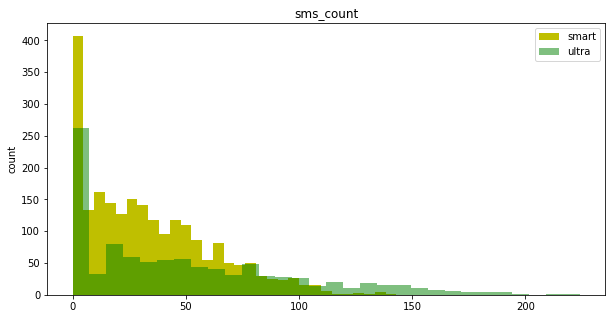

Интернет-трафик. Мы видим, что в среднем пользователи тарифа SMART используют около 17гб интернет-трафика в месяц, а в ULTRA около 20гб. То есть в целом пользователи тарифа SMART в этом пункте тоже приносят дополнительный доход от превышения трафика.

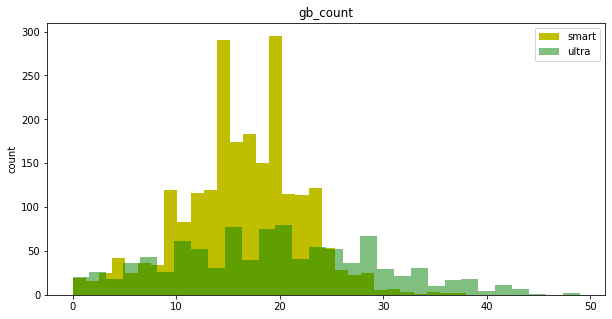

Суммарные траты. Мы видим, что в основном людям хватает лимитов по тарифным планам, и пики у нас идут по оплатам 550 и 1950 руб соответственно. Но также, мы видим, что есть абоненты, которые оплачивают превышения тарифа сверх стоимости, но переплата небольшая, то есть мотивации перейти на другой тариф всё же скорее всего не появится. Исключение составляют лишь пользователи, которые платят свыше 1950 рублей за тариф SMART - им стоит предложить перейти на тариф ULTRA.

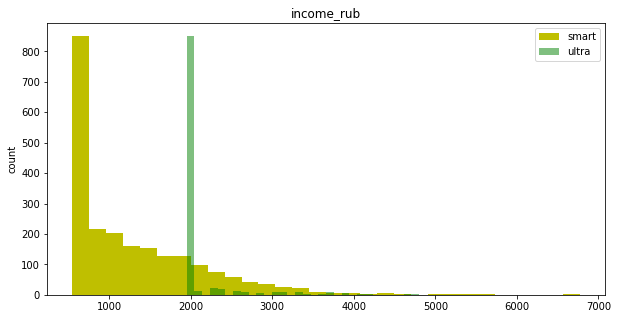

3. Посмотрели на показатели пакетных услуг по каждому тарифу помесячно:

Можно заметить, что пользователи тарифа ULTRA в среднем практически не выбиваются из лимита пакетных услуг, которые включены в тариф. А вот абоненты SMART очень часто превышают лимит, тем самым принося дополнительную прибыль компании за счет оплаты услуг сверх тарифного плана. Виден уверенный рост объемов выручки по тарифу SMART от начала года к концу.

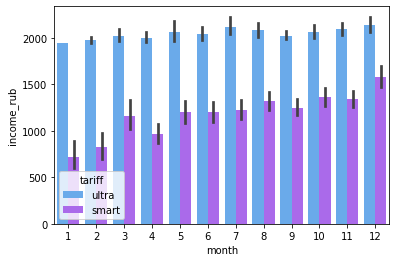

Пользователи обоих тарифов в среднем не превышают свои пакеты минут, но абоненты тарифа ULTRA совершают больше звонков, а у абонентов SMART телефонные разговоры длиннее.

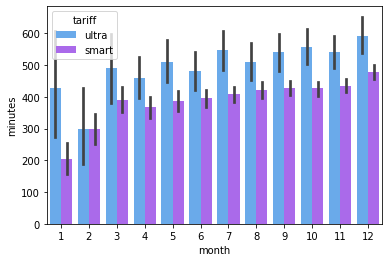, 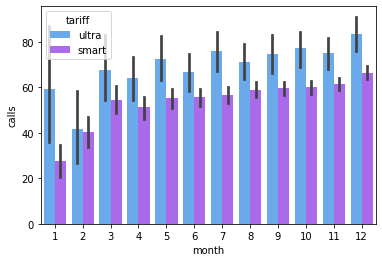

По графику виден рост среднего объёма отправляемых сообщений у пользователей тарифа ULTRA с мая по декабрь, в то время как пользователи SMART вышли на плато в мае месяце и средний объем отправляемых сообщений не меняется, то есть пересматривать объем пакета сообщений в тарифе не требуется.

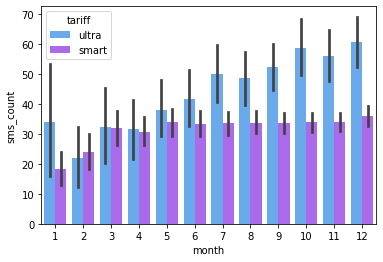

Анализ объема интернет-трафика дает возможность оценить, что в среднем пользователи тарифа SMART чаще выходят за рамки предоставляемого пакета трафика, тем самым оплачивая услуги сверх тарифного плана. В целом по выборке можно судить, что тарифный план SMART более прибыльный для компании.

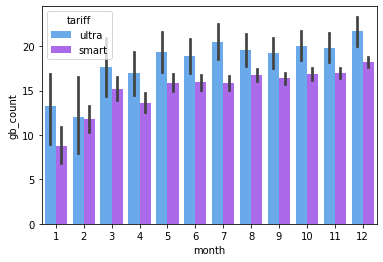


4. Также мы проверили 2 гипотезы и пришли к выводам:

* Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается
* Cредняя выручка пользователей из Москвы и пользователей из других регионов тарифов «Ультра» и «Смарт» не различается, то есть местонахождение абонента не влияет на среднюю выручку

Анализ показал, что условия и пакетные опции тарифа SMART подходят для большинства пользователей этим тарифом. И для многих даже при превышении пакетных опции тариф остаётся более выгодным, нежели тариф ULTRA. Только для совсем небольшого количества клиентов предложение перейти на тарифный план ULTRA будет резонным. 

Тариф ULTRA подходит для клиентов, много и долго разговаривающих по телефону и пользующихся интернет-трафиком в больших объемах. 

Изучив поведение клиентов можно сделать сделать вывод, что тарифный план SMART приносит больше прибыли и является более выгодным для компании в целом, т.к. его абоненты часто переплачивают сверх лимита, в отличие от абонентов ULTRA, которые редко превышают объемы пакетных опций, и стоимость минуты разговоры и интернет-трафика в нём в три раза ниже.